In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from itertools import chain
import glob
import seaborn as sns
import matplotlib.font_manager as font_manager
import seaborn as sns
import matplotlib as mpl
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from collections import Counter
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
register_matplotlib_converters()

In [6]:
sns.set_theme()
mpl.matplotlib_fname()
font_dirs = ['D:\\Software\\Anaconda\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf' ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
mpl.font_manager._rebuild()
result = font_manager.findfont("Rounded Mplus 1c")
print(result)
mpl.rc('font', family='Rounded Mplus 1c')

D:\Software\Anaconda\Lib\site-packages\matplotlib\mpl-data\fonts\ttf\MPLUSRounded1c-Regular.ttf


In [7]:
def extract_engine_data (description, list_em):
    engine_model = []
    for e in list_em:
        em_reg = re.findall(r'\b{}-\w+-?\w*\b'.format(e), description)
        if len(em_reg) != 0 :
          em_reg = map(lambda x : x.split('-')[0],em_reg)
#           em_reg = list(set(em_reg)) 
          engine_model.append(em_reg)
    if len(engine_model) != 0:
      return list(chain(*engine_model))
    else: 
      return 0

def normalize_zero (row,unit_price):
    if row['Quantity'] == 0:
      if row['Quantity'] % unit_price < 2:
        return 1
      else:
        return row['Quantity'] / unit_price
    else:
        return row['Quantity']
    

def check_count_em (row,unit_price):
    if (row['count_em'] == 1) and (row['len_em'] > 1):
       if (row['Cargo Value USD'] < unit_price) or (row['Cargo Value USD'] == unit_price):
         return  round(row['Cargo Value USD']/row['len_em'],2)
       else:
         return unit_price

    elif (row['count_em'] > 1) and (row['len_em'] > 1):
        if (row['Cargo Value USD'] < row['count_em'] * unit_price) or (row['Cargo Value USD'] == row['count_em'] * unit_price):
           return  round(row['Cargo Value USD']/row['Quantity'],2)
#         elif row['Cargo Value USD'] > row['count_em'] * 266.77
#              return  round(row['Cargo Value USD']/row['len_em'],2)
        else:
            return row['count_em'] * unit_price
#             return  round(row['Cargo Value USD']/row['Quantity']*row['count_em'],2)
    elif ((row['count_em'] ==1) and (row['len_em'] == 1)):
       return  round(row['Cargo Value USD']/row['len_em'],2)
    else:
       return row['Cargo Value USD']



def count_length(list_em,em):
    count  = 0
    for i in list_em:
        if i == em:
            count+=1
    return count

In [8]:
# Load list all engine model in GTO
# df_merged = read_csv('list_all_em_GTO.csv',parse_dates=['Register Date'])
df_merged = read_csv('list_all_em_GTO.csv')
df_merged['Register Date'] = pd.to_datetime(df_merged['Register Date'],format='%Y-%m-%d')
df_merged.drop('Unnamed: 0',axis=1,inplace=True)
df_merged.head()

,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,Shipper Address,Consignee,Consignee Address,Quantity,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD
0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",15,ШТ,CIF,3604.0,3017.0,73063.36
1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",5,ШТ,CIF,1765.0,1465.0,37014.64
2,2011-01-17,8407343009,"ДВИГАТЕЛЬ ЗИЛ ,Б/У,БЕНЗИНОВЫЙ,ОБЪЕМ 6000СМ.КУБ...",АМО ЗИЛ,ЗИЛ,ЕКАТЕРИНБУРГ,"RU, RUS, Russia","UA, UKR, Ukraine",ООО ПЕТРУС,"Г.ДРОГОБЫЧ УЛ.ГАЙДАМАЦКАЯ, 7/1",ЗАО АВТОМОБИЛИ И МОТОРЫ УРАЛА,"624130, СВЕРДЛОВСКАЯ ОБЛ., Г.НОВОУРАЛЬСК, УЛ.А...",30,ШТ,CPT,14400.0,14400.0,27000.00
3,2011-01-17,8407343009,"ДВИГАТЕЛЬ ЗИЛ ,Б/У,НЕКОМПЛЕКТНЫЙ,БЕНЗИНОВЫЙ,ОБ...",АМО ЗИЛ,ЗИЛ,ЕКАТЕРИНБУРГ,"RU, RUS, Russia","UA, UKR, Ukraine",ООО ПЕТРУС,"Г.ДРОГОБЫЧ УЛ.ГАЙДАМАЦКАЯ, 7/1",ЗАО АВТОМОБИЛИ И МОТОРЫ УРАЛА,"624130, СВЕРДЛОВСКАЯ ОБЛ., Г.НОВОУРАЛЬСК, УЛ.А...",15,ШТ,CPT,3000.0,3000.0,6894.50
4,2011-01-20,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ В СБОРЕ С КОРОБКОЙ ПЕРЕДА...,MERCEDES - BENZ,MERCEDES - BENZ,ТОЯМА НЬЮ ПОРТ,"JP, JPN, Japan","JP, JPN, Japan","METAL AUTO HOKURIKU CO., LTD","ISHIKAWA KEN KOMATSU SHI SHIRAE MACHI, RO 62",ИП КОЧЕТКОВ ВЯЧЕСЛАВ ВИКТОРОВИЧ,"664019, , Г ИРКУТСК, ПЕР. МИНУСИНСКИЙ Д 10",38,ШТ,FOB,6460.0,6460.0,6536.45


In [9]:
for col in list(df_merged.columns):
 (df_merged[col].dtype ==  'object') and (df_merged[col].fillna(value='unknown',inplace = True)) or (df_merged[col].fillna(value=0, inplace = True))

In [10]:
# Load list engine model
df_list_engine = pd.read_excel('Engine Model _1025.xlsx')
df_list_engine.head()

,Unnamed: 0,メーカー,燃料,買付受付,型式,駆動1,駆動2,駆動3,詳細,車輌型式,KRA売単価,車名,仕入値,EG売価\n（マニ触付）\nW,EG売価\n（マニ触抜/無）\nWO
0,2.0,FIAT,0,×,4,FR,AT,2WD,NaN,NaN,NaN,NaN,NaN,売価確認,売価確認
1,3.0,PORCHE,NaN,×,64,RR,AT,4WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
2,4.0,PORCHE,NaN,×,66,RR,MT,2WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
3,5.0,PORCHE,NaN,×,70,RR,AT,4WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
4,6.0,BENZ,NaN,○,102,FR,AT,2WD,NaN,NaN,NaN,NaN,NaN,40000,0


In [11]:
# Load list engine TOYOTA
df_brand_toyota =  df_list_engine[df_list_engine['メーカー']  == 'TOYOTA']
list_toyota = list(df_brand_toyota['型式'].unique())
list_toyota  = list(map(lambda x: x.split('-')[0],list_toyota))
list_toyota  = list(set(list_toyota))

In [12]:
df_brand_mazda =  df_list_engine[df_list_engine['メーカー']  == 'MAZDA']
list_mazda = list(df_brand_mazda['型式'].unique())
list_mazda  = list(map(lambda x: x.split('-')[0],list_mazda))
list_mazda  = list(set(list_mazda))

In [13]:
df_brand_mitsubishi =  df_list_engine[df_list_engine['メーカー']  == 'MITSUBISHI']
list_mitsubishi = list(df_brand_mitsubishi['型式'].unique())
list_mitsubishi  = list(map(lambda x: x.split('-')[0],list_mitsubishi))
list_mitsubishi  = list(set(list_mitsubishi))

In [14]:
df_brand_honda =  df_list_engine[df_list_engine['メーカー']  == 'HONDA']
list_honda = list(df_brand_honda['型式'].unique())
list_honda  = list(map(lambda x: x.split('-')[0],list_honda))
list_honda  = list(set(list_honda))

In [15]:
df_brand_nissan =  df_list_engine[df_list_engine['メーカー']  == 'NISSAN']
list_nissan = list(df_brand_nissan['型式'].unique())
list_nissan  = list(map(lambda x: x.split('-')[0],list_nissan))
list_nissan  = list(set(list_nissan))

In [16]:
df_brand_subaru =  df_list_engine[df_list_engine['メーカー']  == 'SUBARU']
list_subaru = list(df_brand_subaru['型式'].unique())
list_subaru  = list(map(lambda x: x.split('-')[0],list_subaru))
list_subaru  = list(set(list_subaru))

# Extract list engine of each brand

In [17]:
df_toyota_GTO = df_merged[df_merged.Producer.str.contains('TOYOTA')]
df_toyota_GTO['extracted_engine']  = df_toyota_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_toyota))
df_toyota_GTO['brand'] = 'TOYOTA'
df_toyota_GTO_extracted_em = df_toyota_GTO[df_toyota_GTO['extracted_engine'] !=0]

<ipython-input-17-2c10ef0cfc14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toyota_GTO['extracted_engine']  = df_toyota_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_toyota))
<ipython-input-17-2c10ef0cfc14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toyota_GTO['brand'] = 'TOYOTA'


In [18]:
df_mazda_GTO = df_merged[df_merged.Producer.str.contains('MAZDA')]
df_mazda_GTO['brand'] = 'MAZDA'
df_mazda_GTO['extracted_engine']  = df_mazda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mazda))
df_mazda_GTO_extracted_em = df_mazda_GTO[df_mazda_GTO['extracted_engine'] !=0]

<ipython-input-18-55b0c9e7ffc8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mazda_GTO['brand'] = 'MAZDA'
<ipython-input-18-55b0c9e7ffc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mazda_GTO['extracted_engine']  = df_mazda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mazda))


In [19]:
df_mitsubishi_GTO = df_merged[df_merged.Producer.str.contains('MITSUBISHI')]
df_mitsubishi_GTO['brand'] = 'MITSUBISHI'
df_mitsubishi_GTO['extracted_engine']  = df_mitsubishi_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mitsubishi))
df_mitsubishi_GTO_extracted_em = df_mitsubishi_GTO[df_mitsubishi_GTO['extracted_engine'] !=0]

<ipython-input-19-a3695c5d34da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mitsubishi_GTO['brand'] = 'MITSUBISHI'
<ipython-input-19-a3695c5d34da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mitsubishi_GTO['extracted_engine']  = df_mitsubishi_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mitsubishi))


In [20]:
df_honda_GTO = df_merged[df_merged.Producer.str.contains('HONDA')]
df_honda_GTO['brand'] = 'HONDA'
df_honda_GTO['extracted_engine']  = df_honda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_honda))
df_honda_GTO_extracted_em = df_honda_GTO[df_honda_GTO['extracted_engine'] !=0]

<ipython-input-20-0c8c0f52b4a5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_honda_GTO['brand'] = 'HONDA'
<ipython-input-20-0c8c0f52b4a5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_honda_GTO['extracted_engine']  = df_honda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_honda))


In [21]:
df_nissan_GTO = df_merged[df_merged.Producer.str.contains('NISSAN')]
df_nissan_GTO['brand'] = 'NISSAN'
df_nissan_GTO['extracted_engine']  = df_nissan_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_nissan))
df_nissan_GTO_extracted_em = df_nissan_GTO[df_nissan_GTO['extracted_engine'] !=0]

<ipython-input-21-edd9724bdd48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nissan_GTO['brand'] = 'NISSAN'
<ipython-input-21-edd9724bdd48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nissan_GTO['extracted_engine']  = df_nissan_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_nissan))


In [22]:
df_subaru_GTO = df_merged[df_merged.Producer.str.contains('SUBARU')]
df_subaru_GTO['brand'] = 'SUBARU'
df_subaru_GTO['extracted_engine']  = df_subaru_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_subaru))
df_subaru_GTO_extracted_em = df_subaru_GTO[df_subaru_GTO['extracted_engine'] != 0]

<ipython-input-22-72adf53e9231>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subaru_GTO['brand'] = 'SUBARU'
<ipython-input-22-72adf53e9231>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subaru_GTO['extracted_engine']  = df_subaru_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_subaru))


In [23]:
list_brand  = [df_toyota_GTO_extracted_em,df_mazda_GTO_extracted_em,df_honda_GTO_extracted_em,df_nissan_GTO_extracted_em,df_subaru_GTO_extracted_em]
df_all = pd.concat(list_brand)

In [24]:
df_all['extracted_engine'] = df_all.extracted_engine.map(tuple)
df_all.drop_duplicates()

,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,Shipper Address,Consignee,Consignee Address,Quantity,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand
0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",15,ШТ,CIF,3604.0,3017.0,73063.36,"(2TR, 2TR)",TOYOTA
1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",5,ШТ,CIF,1765.0,1465.0,37014.64,"(2TR, 2TR)",TOYOTA
6,2011-01-06,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,1JZ-0...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",1,ШТ,CFR,150.0,150.0,120.00,"(1JZ,)",TOYOTA
10,2011-01-13,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",3,ШТ,CFR,450.0,450.0,360.00,"(2UZ, 2TR, 5K)",TOYOTA
11,2011-01-17,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",3,ШТ,CFR,450.0,450.0,360.00,"(2UZ, 2TR, 5K)",TOYOTA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258909,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,"HOKKAIDO, HIGASHITAKASU ASAHIKAWA, 2149-13, HI...",ООО ВКС,"690002, ГОРОД ВЛАДИВОСТОК, ПР-КТ КРАСНОГО ЗНАМ...",0,unknown,CFR,200.0,200.0,302.00,"(EJ20,)",SUBARU
258910,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,"HOKKAIDO, HIGASHITAKASU ASAHIKAWA, 2149-13, HI...",ООО ВКС,"690002, ГОРОД ВЛАДИВОСТОК, ПР-КТ КРАСНОГО ЗНАМ...",0,unknown,CFR,200.0,200.0,302.00,"(EJ20,)",SUBARU
258942,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU CORPORATION,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",AL EXPORT,"875-1, KAMONOFU, SINGU, FUKUOKA PREF, KASUYA",ООО КАСТОМ-ВЛ,"690003, ГОРОД ВЛАДИВОСТОК, УЛ НИЖНЕПОРТОВАЯ, Д...",0,unknown,CFR,220.0,220.0,332.20,"(EJ20,)",SUBARU
258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,"920-0209, ISHIKAWA KEN, KANAZAWA-SHI, 1-25 HIG...",ООО АВТОСТОК,"630088, ГОРОД НОВОСИБИРСК, СЕВЕРНЫЙ ПРОЕЗД, Д ...",0,unknown,FOB,2125.0,2070.0,3133.66,"(EJ15,)",SUBARU


In [25]:
df_all['extracted_engine'] = df_all.extracted_engine.map(list)

In [26]:
df_copy = df_all.copy().reset_index()
df_copy['month_year'] = df_copy['Register Date'].dt.strftime('%Y-%m')
df_copy['year'] =  df_copy['Register Date'].dt.strftime('%Y')
df_copy['len_em'] = df_copy['extracted_engine'].map(lambda x : len(set(x)))
df_copy

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_em
0,0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,...,ШТ,CIF,3604.0,3017.0,73063.36,"[2TR, 2TR]",TOYOTA,2011-01,2011,1
1,1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,...,ШТ,CIF,1765.0,1465.0,37014.64,"[2TR, 2TR]",TOYOTA,2011-01,2011,1
2,6,2011-01-06,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,1JZ-0...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,ШТ,CFR,150.0,150.0,120.00,[1JZ],TOYOTA,2011-01,2011,1
3,10,2011-01-13,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,ШТ,CFR,450.0,450.0,360.00,"[2UZ, 2TR, 5K]",TOYOTA,2011-01,2011,3
4,11,2011-01-17,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,ШТ,CFR,450.0,450.0,360.00,"[2UZ, 2TR, 5K]",TOYOTA,2011-01,2011,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37721,258910,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,...,unknown,CFR,200.0,200.0,302.00,[EJ20],SUBARU,2019-12,2019,1
37722,258942,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU CORPORATION,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",AL EXPORT,...,unknown,CFR,220.0,220.0,332.20,[EJ20],SUBARU,2019-12,2019,1
37723,258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,...,unknown,FOB,2125.0,2070.0,3133.66,[EJ15],SUBARU,2019-12,2019,1
37724,259059,2019-12-01,8407343009,"ДВИГАТЕЛЬ ОТ А/М Б/У С АКП ,БЕНЗИНОВЫЙ ОБЪЕМОМ...",SUBARU DAIHATSU,SUBARU DAIHATSU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",UNICO CO LTD,...,unknown,CFR,383.0,383.0,578.00,[FB20],SUBARU,2019-12,2019,1


In [27]:
# Toyota :3S ( 11467＝14.75%), 1NZ (9912＝12.75%) , 1G ( 8744 ＝ 11.25%)

# TOYOTA : EM =  3S

In [28]:
# df_copy.extracted_engine.map(list)
df_3s  = df_copy[df_copy["extracted_engine"].apply(lambda x : '3S' in x)]
df_3s

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_em
7,20,2011-01-25,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: SUBARU...","SUBARU, NISSAN, TOYOTA, HONDA","SUBARU, NISSAN, TOYOTA, HONDA",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","G.E. TRADING CO., LTD",...,ШТ,CFR,3250.0,3250.0,3250.00,[3S],TOYOTA,2011-01,2011,1
13,39,2011-01-13,8407343009,ДВИГАТЕЛЬ А/М Б/У БЕНЗИН С ОБЪЕМОМ БОЛЕЕ 1000С...,"TOYOTA,NISSAN,MMC,SUBARU,MAZDA,HONDA","TOYOTA,NISSAN,MMC,SUBARU,MAZDA,HONDA",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",ДОМИТОРИ ШОКАЙ ИНК,...,ШТ,CFR,5029.0,5029.0,3287.37,"[2TZ, 1JZ, 3S]",TOYOTA,2011-01,2011,3
16,44,2011-01-13,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЕНЗИНОВЫЕ БЫВШ...,TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","SUZAN TRADING CO., LTD",...,ШТ,CFR,6620.0,6620.0,4950.00,"[4E, 4S, 5A, 5E, 3S]",TOYOTA,2011-01,2011,5
17,45,2011-01-13,8407343009,"ДВИГАТЕЛЬ БЕНЗИН.ДЛЯ ЛЕГ.А/М,Б/У,ЯП.ПР-ВА В СБ...","NISSAN, MITSUBISHI,TOYOTA,MAZDA,HONDA,SUBARU,D...","NISSAN, MITSUBISHI, TOYOTA,MAZDA,SUBARU,HONDA,...",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",LEEA CORPORATION,...,ШТ,CFR,10255.0,10255.0,6160.00,[3S],TOYOTA,2011-01,2011,1
19,56,2011-01-14,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ ЛЕГ.А/М,Б/У,ЯП.ПР-ВА:...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",JAPROS CO LTD,...,ШТ,CFR,150.0,150.0,160.00,[3S],TOYOTA,2011-01,2011,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20821,258378,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,TOYOTA MOTOR CO. LTD,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","KR, KOR, Korea",KOS.COM CORPORATION,...,unknown,CFR,205.0,205.0,309.55,[3S],TOYOTA,2019-12,2019,1
20839,258396,2019-12-01,8407343009,"ЗАП.ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ, Б/У: ДВИГАТЕЛИ БЫВШ...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",ROOTS CO. LTD,...,unknown,CFR,300.0,300.0,451.94,[3S],TOYOTA,2019-12,2019,1
20840,258397,2019-12-01,8407343009,"ЗАП.ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ, Б/У: ДВИГАТЕЛИ БЫВШ...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",ROOTS CO. LTD,...,unknown,CFR,300.0,300.0,451.94,[3S],TOYOTA,2019-12,2019,1
20870,258899,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,...,unknown,CFR,200.0,200.0,302.00,[3S],TOYOTA,2019-12,2019,1


In [29]:
df_3s['count_em']  = df_3s['extracted_engine'].map(lambda x: count_length(x,'3S') )

<ipython-input-29-bffbd8317c24>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['count_em']  = df_3s['extracted_engine'].map(lambda x: count_length(x,'3S') )


In [30]:
unit_price = df_3s[(df_3s.Quantity == 1) & (df_3s.count_em==1)].describe().loc[('mean','Cargo Value USD')]
unit_price

243.28073770491804

In [31]:
df_3s['Quantity'] = df_3s.apply(lambda x : normalize_zero (x,unit_price), axis=1)

<ipython-input-31-138da5abc9fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['Quantity'] = df_3s.apply(lambda x : normalize_zero (x,unit_price), axis=1)


In [32]:
df_3s.describe()

,index,HS Code,Quantity,Gross Weight in KG,Net Weight in KG,Cargo Value USD,len_em,count_em
count,5460.000000,5.460000e+03,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000
mean,118801.129670,8.407343e+09,12.430037,3138.426473,3138.046304,3807.914866,3.993956,2.101832
std,81909.187001,0.000000e+00,12.333079,2625.484231,2625.518481,3278.881840,2.478440,1.616422
min,20.000000,8.407343e+09,1.000000,50.000000,50.000000,30.220000,1.000000,1.000000
25%,46528.000000,8.407343e+09,1.000000,1000.000000,1000.000000,1200.000000,2.000000,1.000000
50%,101209.000000,8.407343e+09,10.000000,2642.500000,2642.500000,3088.310000,4.000000,1.000000
75%,209718.250000,8.407343e+09,20.000000,4560.000000,4560.000000,5424.147500,6.000000,3.000000
max,258900.000000,8.407343e+09,83.000000,17857.000000,17857.000000,26101.220000,18.000000,13.000000


In [33]:
df_3s['total_price'] = df_3s.apply(lambda x : check_count_em(x,unit_price),axis=1)
# df_3s.drop(columns = ['total_price_1nz'],inplace = True)

<ipython-input-33-097b22d29e78>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['total_price'] = df_3s.apply(lambda x : check_count_em(x,unit_price),axis=1)


In [34]:
df_3s

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_em,count_em,total_price
7,20,2011-01-25,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: SUBARU...","SUBARU, NISSAN, TOYOTA, HONDA","SUBARU, NISSAN, TOYOTA, HONDA",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","G.E. TRADING CO., LTD",...,3250.0,3250.0,3250.00,[3S],TOYOTA,2011-01,2011,1,1,3250.000000
13,39,2011-01-13,8407343009,ДВИГАТЕЛЬ А/М Б/У БЕНЗИН С ОБЪЕМОМ БОЛЕЕ 1000С...,"TOYOTA,NISSAN,MMC,SUBARU,MAZDA,HONDA","TOYOTA,NISSAN,MMC,SUBARU,MAZDA,HONDA",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",ДОМИТОРИ ШОКАЙ ИНК,...,5029.0,5029.0,3287.37,"[2TZ, 1JZ, 3S]",TOYOTA,2011-01,2011,3,1,243.280738
16,44,2011-01-13,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЕНЗИНОВЫЕ БЫВШ...,TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","SUZAN TRADING CO., LTD",...,6620.0,6620.0,4950.00,"[4E, 4S, 5A, 5E, 3S]",TOYOTA,2011-01,2011,5,1,243.280738
17,45,2011-01-13,8407343009,"ДВИГАТЕЛЬ БЕНЗИН.ДЛЯ ЛЕГ.А/М,Б/У,ЯП.ПР-ВА В СБ...","NISSAN, MITSUBISHI,TOYOTA,MAZDA,HONDA,SUBARU,D...","NISSAN, MITSUBISHI, TOYOTA,MAZDA,SUBARU,HONDA,...",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",LEEA CORPORATION,...,10255.0,10255.0,6160.00,[3S],TOYOTA,2011-01,2011,1,1,6160.000000
19,56,2011-01-14,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ ЛЕГ.А/М,Б/У,ЯП.ПР-ВА:...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",JAPROS CO LTD,...,150.0,150.0,160.00,[3S],TOYOTA,2011-01,2011,1,1,160.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20821,258378,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,TOYOTA MOTOR CO. LTD,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","KR, KOR, Korea",KOS.COM CORPORATION,...,205.0,205.0,309.55,[3S],TOYOTA,2019-12,2019,1,1,309.550000
20839,258396,2019-12-01,8407343009,"ЗАП.ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ, Б/У: ДВИГАТЕЛИ БЫВШ...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",ROOTS CO. LTD,...,300.0,300.0,451.94,[3S],TOYOTA,2019-12,2019,1,1,451.940000
20840,258397,2019-12-01,8407343009,"ЗАП.ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ, Б/У: ДВИГАТЕЛИ БЫВШ...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",ROOTS CO. LTD,...,300.0,300.0,451.94,[3S],TOYOTA,2019-12,2019,1,1,451.940000
20870,258899,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,...,200.0,200.0,302.00,[3S],TOYOTA,2019-12,2019,1,1,302.000000


In [31]:
df_3s[df_3s.total_price> df_3s['Cargo Value USD']]

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_em,count_em,total_price


In [37]:
df_sum_day = df_3s.groupby(['Register Date'])['total_price'].sum().reset_index()
df_sum_month = df_3s.groupby(['month_year'])['total_price'].sum().reset_index()
df_sum_year = df_3s.groupby(['year'])['total_price'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
# df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price.values,index=df_sum_year['year'])

In [38]:
em_series_month.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-10-01', '2011-11-01', '2011-12-01', '2012-01-01',
               '2012-02-01', '2012-03-01', '2012-04-01', '2012-05-01',
               '2012-06-01', '2012-07-01', '2012-08-01', '2012-09-01',
               '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01',
               '2013-02-01', '2013-04-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01',
               '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01',
               '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01',
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
      

In [39]:
em_series = pd.Series(df_sum_day.total_price.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_3s.total_price.values,index=df_3s['Register Date'])
# em_series.index = em_series.index.to_period('M')
# em_series.to_csv('toyota_1nz.csv')

<AxesSubplot:xlabel='Register Date'>

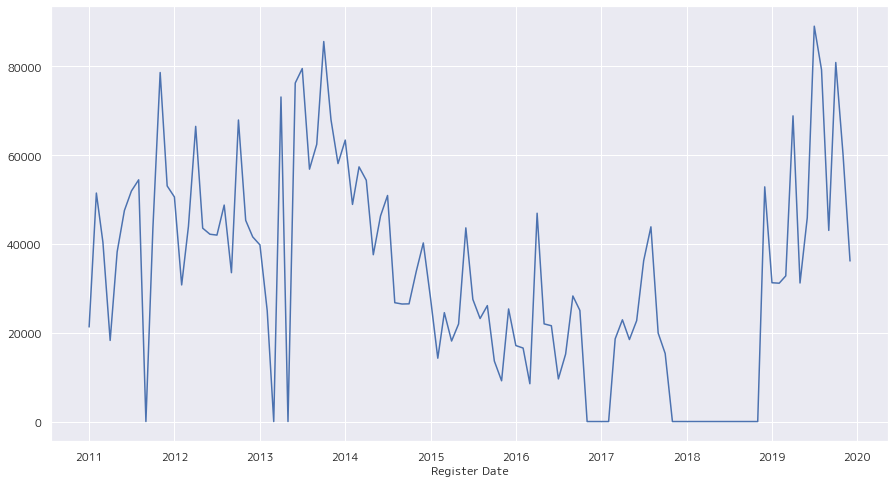

In [35]:
plt.figure(figsize=(15,8))
values = em_series.values
# plot dataset
sns.lineplot(data=em_series.resample('MS').sum())

In [75]:
em_series_month.describe()

count       88.000000
mean     40462.306013
std      19742.940469
min       8514.825820
25%      24888.043033
50%      40019.674795
75%      52176.524262
max      89078.599262
dtype: float64

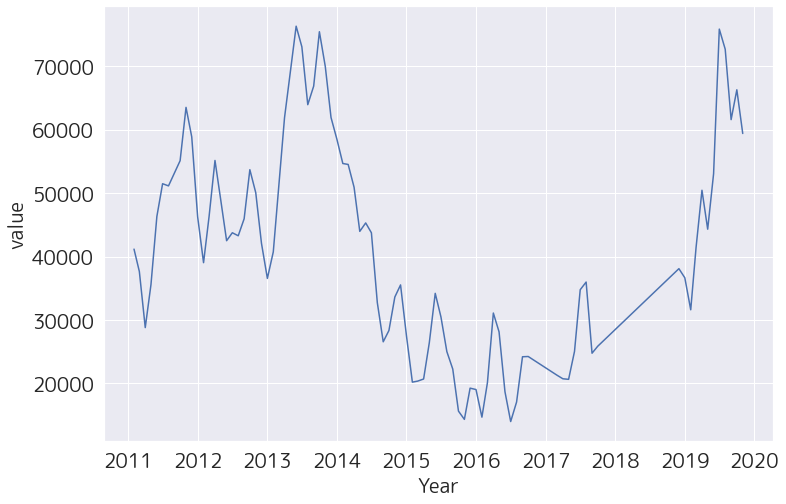

In [80]:
decomposition = seasonal_decompose(em_series_month, model='additive',period = 2)
plt.figure(figsize=(12,8))
plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20, rotation = 0)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('value',fontsize = 20)
plt.plot(decomposition.trend)
# fig = decomposition.seasonal.plot()

In [37]:
def series_to_supervised(data, n_in=4, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [38]:
names = ["Gradient_Boosting", "Decision_Tree", "Extra_Trees", "Random_Forest","LGBM","XGBoost"]
models = [
    GradientBoostingRegressor(),
    DecisionTreeRegressor(max_depth=5),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    LGBMRegressor(),
    XGBRegressor()]

In [43]:
# values = pd.DataFrame(em_series.values)
# dataframe = pd.concat([values.shift(1), values], axis=1)
# dataframe.columns = ['t-1', 't']
# dataframe.dropna(inplace= True)
# target = dataframe.iloc[:,1]
# data = dataframe.iloc[:,:-1]
dataset = series_to_supervised(np.expand_dims(em_series_sample.values,axis=1), n_in=3)
data  = dataset[:,:-1]
target = dataset[:,-1]

In [44]:
# split into train and test sets
size = int(len(em_series_sample) * 0.7)
train_X, test_X = data[0:size], data[size:len(em_series_sample)]
train_y, test_y = target[0:size], target[size:len(em_series_sample)]
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
# model = XGBRegressor()
# model = LGBMRegressor()
model.fit(train_X, train_y)
yhat = model.predict(test_X)
rmse = mean_squared_error(test_y, yhat,squared=False)
mape = mean_absolute_percentage_error(test_y, yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

Test RMSE: 1182.612
Test MAPE: 1.625


In [45]:
rmse = []
mape = []
r_squared = []
for  model in models:
    model.fit(train_X, train_y)
    y_pred  = model.predict(test_X)
#     print(y_pred)
    rmse_score = mean_squared_error(test_y, y_pred,squared=False)
    mape_score = np.mean(np.abs((test_y - y_pred)/test_y)*100)
    r_squared_score  = model.score(test_X,test_y)
    r_squared.append(r_squared_score)
    rmse.append(rmse_score)
    mape.append(mape_score)

In [46]:
df_score = pd.DataFrame()
df_score['MODELS'] = names
df_score['R_SQUARED'] = r_squared
df_score['RMSE'] = rmse
df_score['MAPE'] = mape
df_score['RMSE'] = round(df_score['RMSE'],3)
df_score['MAPE'] = round(df_score['MAPE'],3)
df_score['R_SQUARED'] = round(df_score['R_SQUARED'],3)

df_score

,MODELS,R_SQUARED,RMSE,MAPE
0,Gradient_Boosting,-0.252,635.162,116.212
1,Decision_Tree,-0.192,619.773,111.773
2,Extra_Trees,-1.778,946.063,157.071
3,Random_Forest,-1.459,890.211,153.470
4,LGBM,-0.641,727.071,134.279
5,XGBoost,-2.059,992.790,143.089


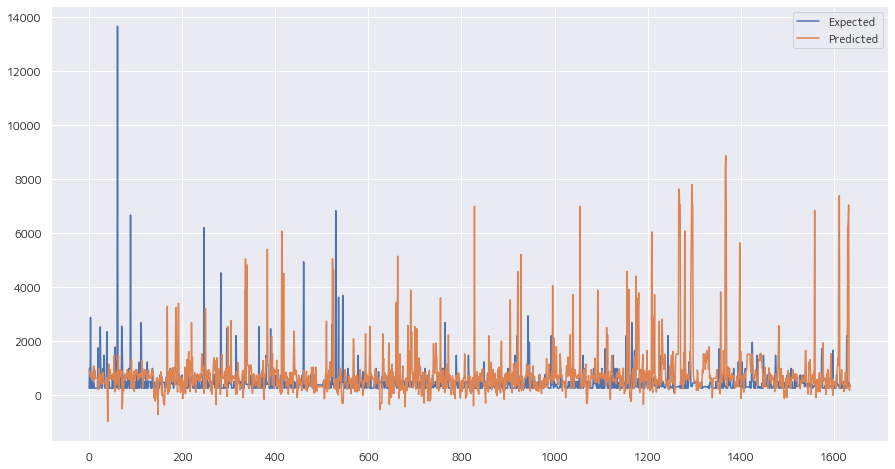

In [47]:
plt.figure(figsize=(15,8))
plt.plot(test_y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

predicted=249.110831, expected=604.000000
predicted=454.941386, expected=207.080536
predicted=393.281662, expected=347.300000
predicted=281.521146, expected=309.550000
predicted=327.259022, expected=286.510000
predicted=297.318364, expected=286.330000
predicted=286.414440, expected=286.330000
predicted=286.330000, expected=414.161071
predicted=354.193843, expected=709.700000
predicted=571.060350, expected=1425.050000
predicted=1089.494335, expected=2916.230000
predicted=2216.972143, expected=287.870000
predicted=1521.251007, expected=301.740000
predicted=295.236471, expected=301.740000
predicted=301.740000, expected=621.241607
predicted=471.429904, expected=350.310000
predicted=477.348835, expected=207.080536
predicted=274.239109, expected=694.610000
predicted=466.009922, expected=347.000000
predicted=509.994876, expected=302.000000
predicted=323.100200, expected=4348.800000
predicted=2451.199620, expected=288.910000
predicted=2196.707653, expected=271.560000
predicted=279.697535, expe

predicted=401.968941, expected=228.010000
predicted=218.161555, expected=224.990000
predicted=226.411073, expected=226.500000
predicted=225.789463, expected=229.520000
predicted=228.098926, expected=228.010000
predicted=228.720537, expected=414.161071
predicted=326.566889, expected=828.322143
predicted=633.441051, expected=1388.570000
predicted=1124.967550, expected=302.000000
predicted=813.296683, expected=302.000000
predicted=302.000000, expected=375.000000
predicted=340.653479, expected=382.500000
predicted=378.971250, expected=414.161071
predicted=399.264538, expected=207.080536
predicted=304.512067, expected=390.000000
predicted=303.935913, expected=397.500000
predicted=393.971244, expected=330.000000
predicted=361.758810, expected=207.080536
predicted=264.914117, expected=207.080536
predicted=207.080536, expected=667.500000
predicted=450.873067, expected=207.080536
predicted=423.713069, expected=1035.402679
predicted=645.642563, expected=207.080536
predicted=596.873198, expected=

predicted=1005.977091, expected=621.241607
predicted=1137.696675, expected=1678.110000
predicted=1180.126995, expected=207.080536
predicted=900.372040, expected=207.080536
predicted=207.080536, expected=347.300000
predicted=281.230225, expected=207.080536
predicted=273.150469, expected=1035.402679
predicted=645.096580, expected=1035.402679
predicted=1035.402679, expected=271.800000
predicted=631.583993, expected=1242.483214
predicted=785.081611, expected=1035.402679
predicted=1132.977022, expected=828.322143
predicted=925.895102, expected=1656.644286
predicted=1266.339100, expected=207.080536
predicted=890.249933, expected=543.600000
predicted=385.018676, expected=543.600000
predicted=543.600000, expected=543.600000
predicted=543.600000, expected=543.600000
predicted=543.600000, expected=543.600000
predicted=543.600000, expected=543.600000
predicted=543.600000, expected=207.080536
predicted=365.660002, expected=207.080536
predicted=207.080536, expected=207.080536
predicted=207.080536, 

predicted=726.444950, expected=288.410000
predicted=640.029247, expected=302.000000
predicted=295.603365, expected=207.080536
predicted=251.757899, expected=241.270000
predicted=225.177465, expected=414.161071
predicted=332.783608, expected=207.080536
predicted=304.550984, expected=414.161071
predicted=316.690130, expected=207.080536
predicted=304.551970, expected=414.161071
predicted=316.689144, expected=414.161071
predicted=414.161071, expected=621.241607
predicted=523.770104, expected=414.161071
predicted=511.633068, expected=207.080536
predicted=304.551180, expected=621.241607
predicted=426.297488, expected=256.670000
predicted=428.275206, expected=256.670000
predicted=256.670000, expected=256.670000
predicted=256.670000, expected=256.670000
predicted=256.670000, expected=256.670000
predicted=256.670000, expected=337.500000
predicted=299.453535, expected=828.322143
predicted=597.295644, expected=414.161071
predicted=609.107624, expected=414.161071
predicted=414.161071, expected=207

predicted=1011.429940, expected=279.350000
predicted=440.380124, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=1449.563750
predicted=898.402327, expected=385.760000
predicted=886.867465, expected=279.350000
predicted=329.467776, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=337.500000
predicted=310.112102, expected=345.000000
predicted=341.467598, expected=1995.190000
predicted=1217.974224, expected=1710.160000
predicted=1844.381726, expected=1242.483214
predicted=1462.705944, expected=1242.483214
predicted=1242.483214, expected=414.161071
predicted=804.198302, expected=1035.402679
predicted=742.862763, expected=621.241607
predicted=816.271377, expected=414.161071
predicted=511.672488, expected=1035.402679
predicted=742.861633, 

predicted=1192.723630, expected=621.241607
predicted=523.940786, expected=828.322143
predicted=731.022616, expected=414.161071
predicted=608.762835, expected=207.080536
predicted=304.377994, expected=207.080536
predicted=207.080536, expected=207.080536
predicted=207.080536, expected=414.161071
predicted=316.864016, expected=1035.402679
predicted=743.520699, expected=621.241607
predicted=815.832731, expected=279.350000
predicted=439.978194, expected=271.800000
predicted=275.347113, expected=279.350000
predicted=275.802887, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=207.080536
predicted=241.033914, expected=207.080536
predicted=207.080536, expected=337.500000
predicted=276.226826, expected=207.080536
predicted=268.353829, expected=354.000000
predicted=284.974559, expected=362.400000
predicted=358.453536, expected=362.400000
predicted=362.400000, expected=362.400000
predicted=362.400000, expected=6

predicted=382.698066, expected=414.161071
predicted=418.222473, expected=207.080536
predicted=304.434846, expected=1449.563750
predicted=865.408786, expected=347.610000
predicted=865.764889, expected=347.610000
predicted=347.610000, expected=279.350000
predicted=311.443012, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=271.800000
predicted=275.349695, expected=271.800000
predicted=271.800000, expected=271.800000
predicted=271.800000, expected=271.800000
predicted=271.800000, expected=271.800000
predicted=271.800000, expected=271.800000
predicted=271.800000, expected=271.800000
predicted=271.800000, expected=271.800000
predicted=271.800000, expected=271.800000
predicted=271.800000, expected=271.800000
predicted=271.800000, expected=207.080536
predicted=237.508940, expected=41

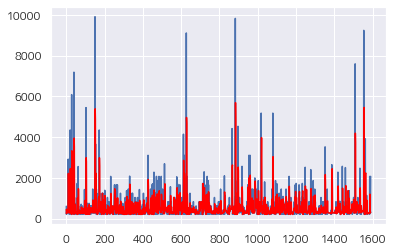

In [366]:
from statsmodels.tsa.arima.model import ARIMA

X = em_series_sample.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = mean_squared_error(test, predictions,squared=False)
mape = mean_absolute_percentage_error(test, predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency informa

RMSE: 54845.276
MAPE: 1.201


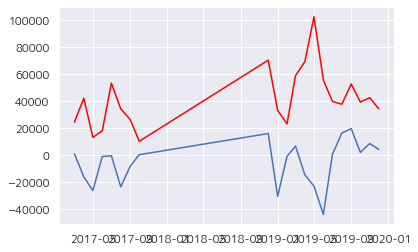

In [67]:
X = em_series.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
# predictions = list()
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=(5,1,1))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
# warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
#                         FutureWarning)
# rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
# mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
model = ARIMA(em_series, order=(4,1,1))
results = model.fit()
pred = results.predict(start='2017-01', dynamic=False)
y_forecasted = pred
y_truth = em_series['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(y_forecasted)
plt.plot(y_truth, color='red')
plt.show()

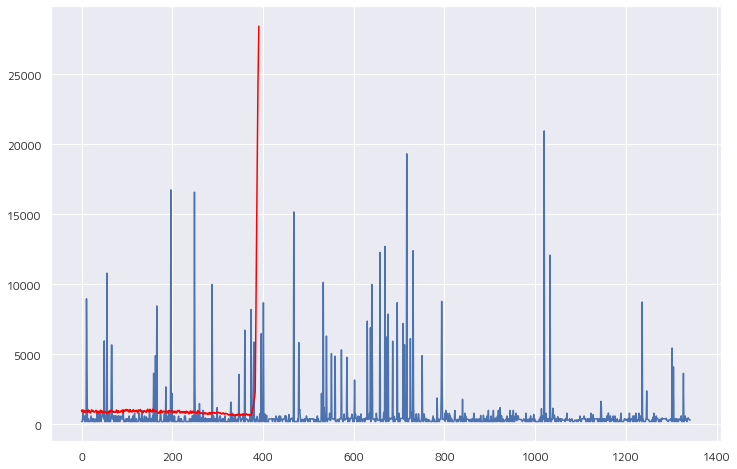

In [69]:
plt.figure(figsize=(12,8))
# plt.plot(np.exp(predictions), color='red')
# plt.xticks(rotation = 90)
# sns.lineplot(x=list(df_sum_month['month_year'][size:len(X)]),y=np.exp(test),data=np.exp(test))
# plt.legend(loc='upper left', labels=['forecast','test'])
plt.plot(np.exp(test))
plt.plot(np.exp(predictions), color='red')
plt.show()

In [71]:
em_series

Register Date
2011-01-12     4288.960482
2011-01-14      397.526988
2011-01-17      795.053976
2011-01-20     3555.053976
2011-01-21     3672.763494
                  ...     
2019-08-01    37537.382771
2019-09-01    52596.581205
2019-10-01    39207.123855
2019-11-01    42373.093855
2019-12-01    34137.352289
Length: 1304, dtype: float64

In [72]:
X = np.log(em_series_sample).values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions = list()
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=(5,1,0))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
# warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA')
# rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
# mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
model = ARIMA(em_series_sample, order=(4,1,1))
results = model.fit()
pred = results.predict(start='2017-01', dynamic=False)
y_forecasted = pred
y_truth = em_series['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(y_forecasted)
plt.plot(y_truth, color='red')
plt.show()

# plot forecasts against actual outcomes
# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency informa

KeyError: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'

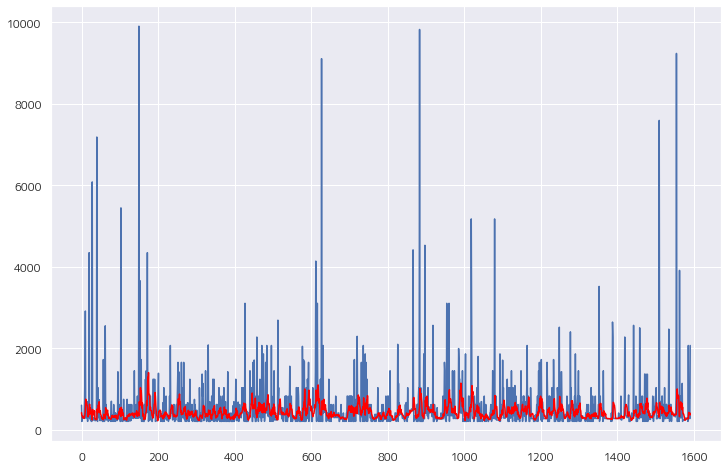

In [488]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(test))
plt.plot(np.exp(predictions), color='red')
plt.show()

ValueError: arrays must all be same length

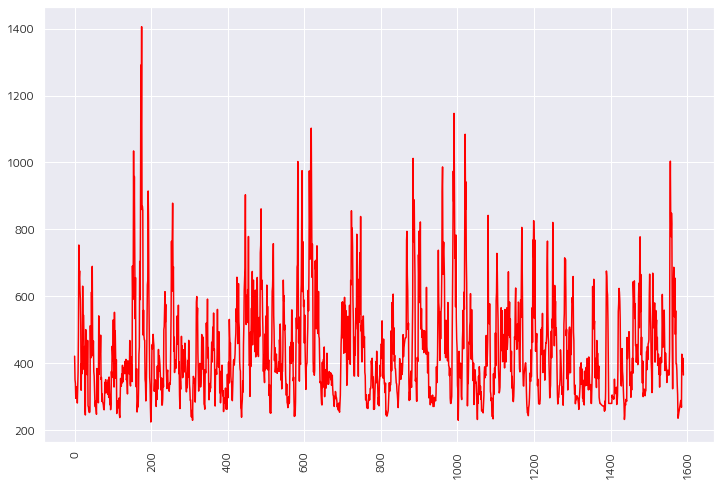

In [462]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
sns.lineplot(x=list(df_sum_day['Register Date'][size:len(X)]),y=np.exp(test),data=np.exp(test))
plt.legend(loc='upper left', labels=['forecast','test'])

In [188]:
X = np.log(em_series_month).values
size = int(len(X) * 0.7)
train, test = X[0:67], X[67:len(X)]
history = [x for x in train]
predictions = list()
# model = ARIMA(np.log(em_series_month), order=(5,1,0))
# results = model.fit()
# pred = results.predict(start='2017-01', dynamic=False)
# y_forecasted = np.exp(pred)
# y_truth = em_series_month['2017-01-01':]
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.xticks(rotation = 90)
# plt.plot(y_forecasted,color='red')
# plt.plot(em_series_month)
# plt.show()
#walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(4,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=9.828734, expected=9.832168
predicted=9.921451, expected=10.039907
predicted=10.152487, expected=9.823957
predicted=10.020373, expected=10.031564
predicted=10.004513, expected=10.497983
predicted=10.235741, expected=10.688980
predicted=10.315709, expected=9.900046
predicted=10.139824, expected=9.637351
predicted=10.145508, expected=10.875721
predicted=10.580104, expected=10.350506
predicted=10.135096, expected=10.347224
predicted=10.194655, expected=10.398680
predicted=10.537505, expected=11.140031
predicted=10.622964, expected=10.348685
predicted=10.408636, expected=10.734868
predicted=10.593052, expected=11.397274
predicted=10.956602, expected=11.280608
predicted=10.778795, expected=10.670480
predicted=10.794229, expected=11.300927
predicted=11.176628, expected=11.006209
predicted=10.970708, expected=10.495996
RMSE: 18784.004
MAPE: 0.322


In [189]:
# plt.xticks(rotation = 90)
# plt.plot_date(df_sum_month['month_year'][size:len(X)], np.exp(predictions))
# list_time_test = list(df_sum_month['month_year'][size:len(X)])
# list_time_test

# df_sum_month.reset_index(inplace=True)
# df_sum_month
# df_sum_month['month_year'] = df_sum_month['month_year'].astype(str)
list_datetime = list(df_sum_month['month_year'][67:len(X)])
# # list_datetime = list(df_sum_month.reset_index()['month_year'][size:len(X)])
# list_datetime
df_sum_month[df_sum_month['month_year'].map(lambda x: '2017' in x)]

,month_year,total_price
67,2017-03-01,18623.282787
68,2017-04-01,22923.247951
69,2017-05-01,18470.990902
70,2017-06-01,22732.802049
71,2017-07-01,36242.333852
72,2017-08-01,43869.751967
73,2017-09-01,19931.294672
74,2017-10-01,15326.686475


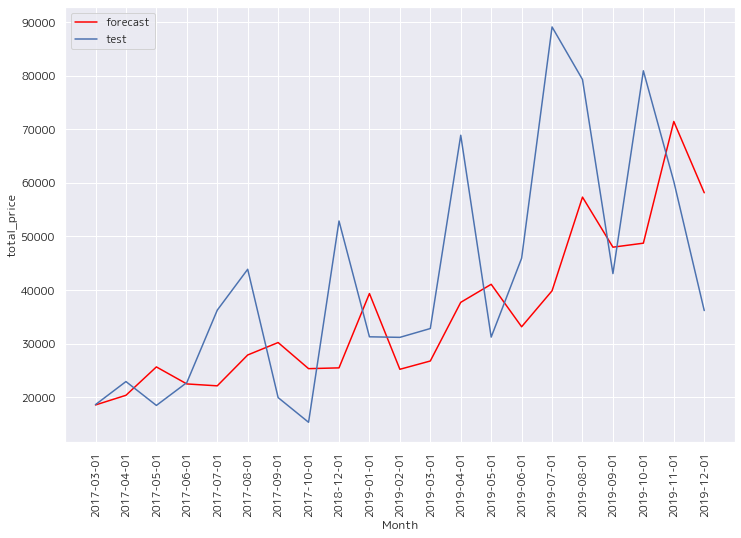

In [190]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[67:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])

# plt.figure(figsize=(12,8))
# plt.plot(np.exp(predictions), color='red')
# plt.plot(em_series_month)
# plt.xticks(rotation = 90)
# plt.ylabel('revenue')
# # sns.lineplot(x=list(df_sum_year['year']),y='total_price_1g',data=df_sum_year)
# plt.legend(loc='best', labels=['forecast','test'])

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will b

RMSE: 354397.410
MAPE: 0.810


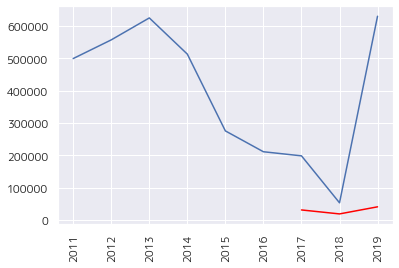

In [192]:
# X = np.log(em_series_year).values
X = em_series_year.values
# size = int(len(X) * 0.5)
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
model = ARIMA(em_series_year, order=(3,1,0))
results = model.fit()
pred = results.predict(start='2017-01', dynamic=False)
y_forecasted = pred
y_truth = em_series_year['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.xticks(rotation = 90)
plt.plot(y_forecasted,color='red')
plt.plot(em_series_year)
plt.show()
# predictions = list()
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=(1,1,0))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
# rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
# mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

In [193]:
# df_sum_year.reset_index(inplace=True)
# df_sum_year['year'] = df_sum_year['year'].astype(str)
list_datetime = list(df_sum_year['year'][size:len(X)])
# # list_datetime = list(df_sum_month.reset_index()['month_year'][size:len(X)])
# list_datetime
list(df_sum_year['year'][6:])

[Timestamp('2017-01-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00')]

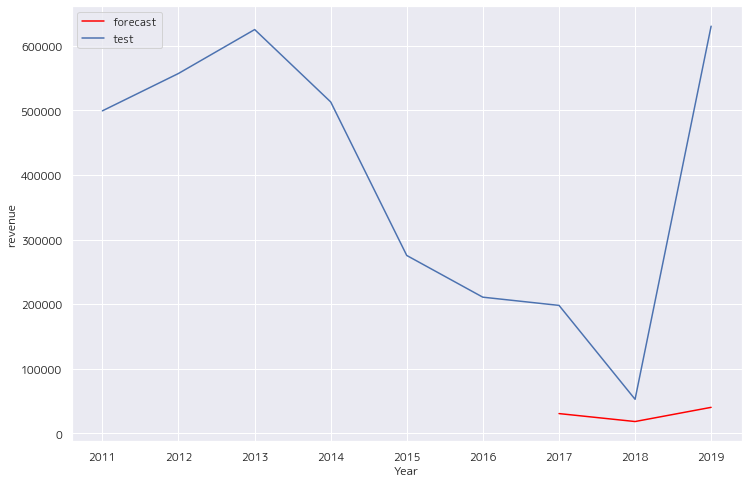

In [194]:
plt.figure(figsize=(12,8))
plt.plot(y_forecasted, color='red')
plt.plot(em_series_year)
# plt.xticks(rotation = 90)
plt.xlabel('Year')
plt.ylabel('revenue')
# sns.lineplot(x=list(df_sum_year['year']),y='total_price_1g',data=df_sum_year)
plt.legend(loc='best', labels=['forecast','test'])

In [40]:
mod =SARIMAX(em_series_month,
                                order=(1, 0, 1),
                                seasonal_order=(2, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9521      0.052     18.410      0.000       0.851       1.053
ma.L1         -0.6492      0.204     -3.182      0.001      -1.049      -0.249
ar.S.L12      -0.1979      0.433     -0.457      0.647      -1.046       0.650
ar.S.L24      -0.1584      0.320     -0.495      0.620      -0.785       0.468
ma.S.L12      -0.9526      0.101     -9.477      0.000      -1.150      -0.756
sigma2      4.344e+08   2.61e-10   1.66e+18      0.000    4.34e+08    4.34e+08


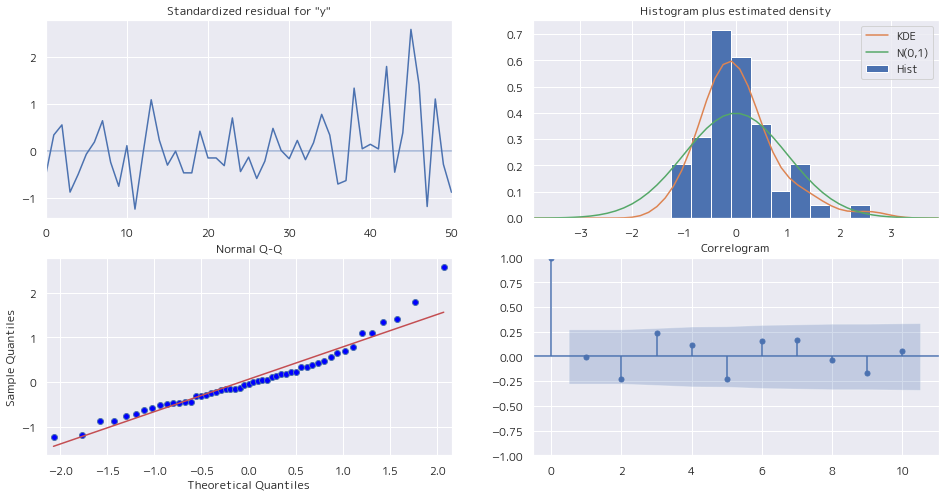

In [41]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

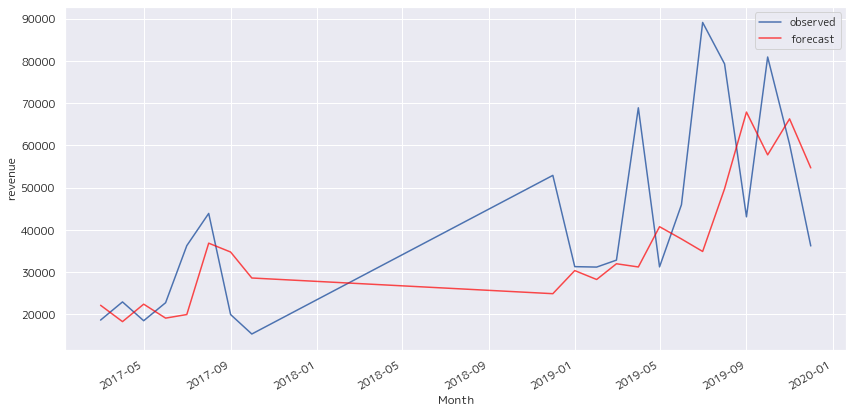

In [42]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [43]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 20102.069
MAPE: 0.340


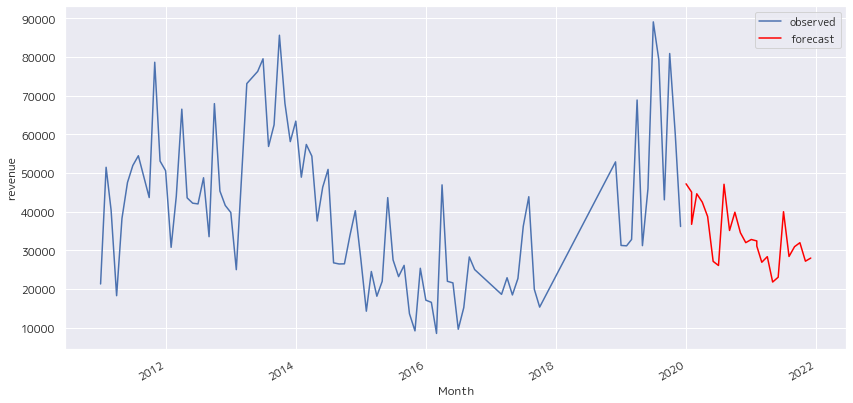

In [44]:
index = pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_month.plot(label='observed', figsize=(14, 7),)
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [46]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2020-01-01,47204.065799
2020-02-01,45073.717296
2020-03-01,44629.407964
2020-02-01,36733.353041
2020-04-01,42461.628941
2020-05-01,38743.992403
2020-06-01,27150.441591
2020-07-01,26089.414326
2020-08-01,47088.551946
2020-09-01,35140.910515


In [47]:
mod =SARIMAX(em_series_year,
                                order=(1, 0, 0),
                                seasonal_order=(2, 1, 1, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2331   2.94e+04   7.92e-06      1.000   -5.77e+04    5.77e+04
ar.S.L2       -0.0883   3.74e+04  -2.36e-06      1.000   -7.33e+04    7.33e+04
ar.S.L4       -1.3191   2.57e+04  -5.13e-05      1.000   -5.04e+04    5.04e+04
ma.S.L2       -0.4813   7.23e+04  -6.66e-06      1.000   -1.42e+05    1.42e+05
sigma2      6.777e+10      0.061   1.12e+12      0.000    6.78e+10    6.78e+10


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3098: UserWarning: Early subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  warnings.warn('Early subset of data for variable %d'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3103: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  warnings.warn('Later subset of data for variable %d'


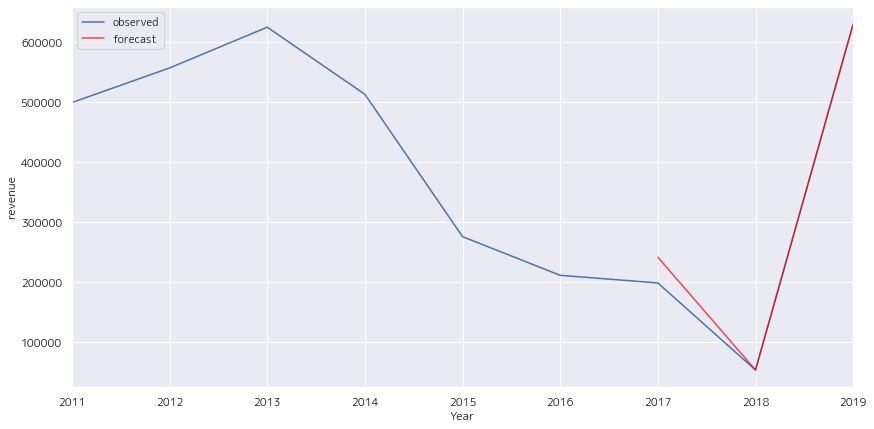

In [48]:
pred = results.get_prediction(start='2017-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_year['2011-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7, figsize=(14, 7),color='red')

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [49]:
y_forecasted = pred.predicted_mean
y_truth = em_series_year['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 24818.751
MAPE: 0.072


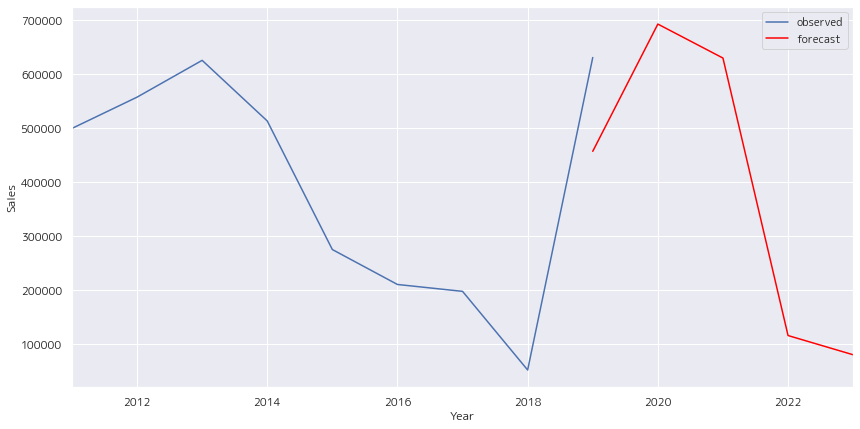

In [52]:
index = pd.to_datetime(['2019', '2020','2021','2022','2023'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_year.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [54]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2019-01-01,456779.529100
2020-01-01,691786.630517
2021-01-01,629026.891982
2022-01-01,116533.408786
2023-01-01,81011.785757


In [136]:
df_copy

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_em
0,0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,...,ШТ,CIF,3604.0,3017.0,73063.36,"[2TR, 2TR]",TOYOTA,2011-01,2011,1
1,1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,...,ШТ,CIF,1765.0,1465.0,37014.64,"[2TR, 2TR]",TOYOTA,2011-01,2011,1
2,6,2011-01-06,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,1JZ-0...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,ШТ,CFR,150.0,150.0,120.00,[1JZ],TOYOTA,2011-01,2011,1
3,10,2011-01-13,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,ШТ,CFR,450.0,450.0,360.00,"[2TR, 2UZ, 5K]",TOYOTA,2011-01,2011,3
4,11,2011-01-17,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,ШТ,CFR,450.0,450.0,360.00,"[2TR, 2UZ, 5K]",TOYOTA,2011-01,2011,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37721,258910,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,...,unknown,CFR,200.0,200.0,302.00,[EJ20],SUBARU,2019-12,2019,1
37722,258942,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU CORPORATION,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",AL EXPORT,...,unknown,CFR,220.0,220.0,332.20,[EJ20],SUBARU,2019-12,2019,1
37723,258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,...,unknown,FOB,2125.0,2070.0,3133.66,[EJ15],SUBARU,2019-12,2019,1
37724,259059,2019-12-01,8407343009,"ДВИГАТЕЛЬ ОТ А/М Б/У С АКП ,БЕНЗИНОВЫЙ ОБЪЕМОМ...",SUBARU DAIHATSU,SUBARU DAIHATSU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",UNICO CO LTD,...,unknown,CFR,383.0,383.0,578.00,[FB20],SUBARU,2019-12,2019,1


In [57]:
df_1nz  = df_copy[df_copy["extracted_engine"].apply(lambda x : '1NZ' in x)]
df_1nz

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_em
12,36,2011-01-12,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ Б/У СМ. ДОПОЛНЕНИЕ ДВИГАТ...,"TOYOTA MOTOR CORP.,NISSAN MOTOR CORP.,SUBARU M...","TOYOTA, MAZDA, SUBARU, MITSUBISHI, HONDA,MERCEDES",НАГОЯ,"JP, JPN, Japan","JP, JPN, Japan","M S PLANNING CO., LTD.",...,ШТ,FOB,9230.0,9230.0,7665.00,"[1NZ, 1NZ]",TOYOTA,2011-01,2011,1
20,59,2011-01-14,8407343009,ДВИГАТЕЛЬ А/М Б/У БЕНЗИН С ОБЪЕМОМ БОЛЕЕ 1000С...,"TOYOTA,NISSAN,MMC,SUBARU,MAZDA,HONDA","TOYOTA,NISSAN,MMC,SUBARU,MAZDA,HONDA",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",DOMITORI SHOKAI INC.,...,ШТ,CFR,7190.0,7190.0,4669.07,"[1NZ, 1MZ, 1JZ]",TOYOTA,2011-01,2011,3
27,77,2011-01-19,8407343009,ПРОЧИЕ БЕНЗИНОВЫЕ ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАН...,"TOYOTA, MMC","TOYOTA, MMC",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","TSUBAKI JIDOUSHA CO., LTD",...,ШТ,CFR,2440.0,2440.0,1828.20,"[1NZ, 1SZ, 2NZ, 1JZ]",TOYOTA,2011-01,2011,4
51,948,2011-01-13,8407343009,ДВИГАТЕЛИ БЕНЗИН. С РАБ.ОБЪЕМОМ ДВИГАТЕЛЯ 1500...,"TOYOTA MOTOR CO LTD,MITSUBISHI MOTOR CO LTD, F...","TOYOTA,MMC,SUBARU,MAZDA,HONDA,NISSAN",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",SCP-TRANS LLS,...,ШТ,CFR,5630.0,5630.0,2420.00,"[1NZ, 4S, 5A, 5A, 4A, 4A, 4A]",TOYOTA,2011-01,2011,4
55,975,2011-01-18,8407343009,ДВИГАТЕЛИ БЕНЗ.С НАВЕСНЫМ ОБОРУД.БЫВШ.В УПОТР....,"TOYOTA MOTOR CORP., NISSAN MOTOR COMP., MAZDA ...","TOYOTA, NISSAN, MAZDA, HONDA, MITSUBISHI",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",HASEGAWA MOTOR COMPANY LTD.,...,ШТ,CFR,3520.0,3520.0,3460.00,"[1NZ, 1NZ, 1NZ, 4S, 3S, 2SZ, 1AZ, 1ZZ]",TOYOTA,2011-01,2011,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20894,259153,2019-12-01,8407343009,ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М БЫВШИЕ В УПОТРЕБЛЕНИИ: ...,TOYOTA MOTOR CO.,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",PIONEER COMPANY LTD.,...,unknown,CFR,225.0,225.0,339.75,[1NZ],TOYOTA,2019-12,2019,1
20895,259154,2019-12-01,8407343009,ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М БЫВШИЕ В УПОТРЕБЛЕНИИ: ...,TOYOTA MOTOR CO.,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",PIONEER COMPANY LTD.,...,unknown,CFR,185.0,185.0,279.35,[1NZ],TOYOTA,2019-12,2019,1
20896,259155,2019-12-01,8407343009,ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М БЫВШИЕ В УПОТРЕБЛЕНИИ: ...,TOYOTA MOTOR CO.,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",PIONEER COMPANY LTD.,...,unknown,CFR,230.0,230.0,347.30,[1NZ],TOYOTA,2019-12,2019,1
20897,259156,2019-12-01,8407343009,ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М БЫВШИЕ В УПОТРЕБЛЕНИИ: ...,TOYOTA MOTOR CO.,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",PIONEER COMPANY LTD.,...,unknown,CFR,182.0,182.0,274.82,[1NZ],TOYOTA,2019-12,2019,1


In [58]:
df_1nz['count_em']  = df_1nz['extracted_engine'].map(lambda x: count_length(x,'1NZ'))
unit_price_1nz = df_1nz[(df_1nz.Quantity == 1) & (df_1nz.count_em==1)].describe().loc[('mean','Cargo Value USD')]
df_1nz['Quantity'] = df_1nz.apply(lambda x : normalize_zero (x,unit_price_1nz), axis=1)
df_1nz['total_price'] = df_1nz.apply(lambda x : check_count_em(x,unit_price_1nz),axis=1)

<ipython-input-58-dcb02c1a9bca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1nz['count_em']  = df_1nz['extracted_engine'].map(lambda x: count_length(x,'1NZ'))
<ipython-input-58-dcb02c1a9bca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1nz['Quantity'] = df_1nz.apply(lambda x : normalize_zero (x,unit_price_1nz), axis=1)
<ipython-input-58-dcb02c1a9bca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [59]:
df_1g  = df_copy[df_copy["extracted_engine"].apply(lambda x : '1G' in x)]
df_1g

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_em
8,28,2011-01-12,8407343009,ДВИГАТЕЛЬ А/М Б/У БЕНЗИН С ОБЪЕМОМ БОЛЕЕ 1000С...,"HONDA,MAZDA,MITSUBISHI,NISSAN,TOYOTA,DAIHATSU","HONDA,MAZDA,MITSUBISHI,NISSAN,TOYOTA,DAIHATSU",ХАКАТА,"JP, JPN, Japan","JP, JPN, Japan","МАРУКО ШОДЖИ КО., ЛТД",...,ШТ,FOB,5600.0,5600.0,3692.67,[1G],TOYOTA,2011-01,2011,1
11,34,2011-01-12,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С РАБОЧИМ ОБЪЁМОМ ДВИГАТЕ...,TOYOTA,HONDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","JAPANTREK CO.,LTD",...,ШТ,CFR,6825.0,6825.0,3780.00,"[5S, 1G, 1ZZ, 1ZZ]",TOYOTA,2011-01,2011,3
22,63,2011-01-17,8407343009,ЗАПАСНЫЕ ЧАСТИ ОТ АВТОМОБИЛЯ БЫВШЕГО В УПОТРЕБ...,"TOYOTA , HONDA","TOYOTA , HONDA",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","SUNRISE SERVIS CO.,LTD",...,ШТ,CFR,3995.0,3995.0,1326.00,"[1G, 3S]",TOYOTA,2011-01,2011,2
23,66,2011-01-17,8407343009,ДВИГАТЕЛЬ А/М Б/У БЕНЗИН С ОБЪЕМОМ БОЛЕЕ 1000С...,"TOYOTA,NISSAN,MITSUBISHI,SUBARU,HONDA","TOYOTA,NISSAN,MITSUBISHI,SUBARU,HONDA",ХАКАТА,"JP, JPN, Japan","JP, JPN, Japan",ФУШИКАМИ ШОКАЙ,...,ШТ,FOB,3250.0,3250.0,2101.47,"[2NZ, 1G, 3S]",TOYOTA,2011-01,2011,3
24,67,2011-01-17,8407343009,ДВИГАТЕЛЬ А/М Б/У БЕНЗИН С ОБЪЕМОМ БОЛЕЕ 1000С...,"TOYOTA,HONDA,SUZUKI,MAZDA,SUBARU","TOYOTA,HONDA,SUZUKI,MAZDA,SUBARU",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","СОУГОЙ КО., ЛТД.",...,ШТ,CFR,2950.0,2950.0,1926.75,"[5S, 2JZ, 1G]",TOYOTA,2011-01,2011,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20823,258380,2019-12-01,8407343009,ЗАП.ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ. Б/У: ДВИГАТЕЛИ БЫВШ...,TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",ROOTS CO. LTD,...,unknown,CFR,300.0,300.0,451.94,[1G],TOYOTA,2019-12,2019,1
20861,258884,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,TOYOTA MOTOR CO. LTD,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",AL EXPORT,...,unknown,CFR,220.0,220.0,332.20,[1G],TOYOTA,2019-12,2019,1
20863,258886,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,TOYOTA MOTOR CO. LTD,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",AL EXPORT,...,unknown,CFR,220.0,220.0,332.20,[1G],TOYOTA,2019-12,2019,1
20864,258893,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,...,unknown,CFR,200.0,200.0,302.00,[1G],TOYOTA,2019-12,2019,1


In [60]:
df_1g['count_em']  = df_1g['extracted_engine'].map(lambda x: count_length(x,'1G'))
unit_price_1g = df_1g[(df_1g.Quantity == 1) & (df_1g.count_em==1)].describe().loc[('mean','Cargo Value USD')]
df_1g['Quantity'] = df_1g.apply(lambda x : normalize_zero (x,unit_price_1g), axis=1)
df_1g['total_price'] = df_1g.apply(lambda x : check_count_em(x,unit_price_1g),axis=1)

<ipython-input-60-7f1aba371bb3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1g['count_em']  = df_1g['extracted_engine'].map(lambda x: count_length(x,'1G'))
<ipython-input-60-7f1aba371bb3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1g['Quantity'] = df_1g.apply(lambda x : normalize_zero (x,unit_price_1g), axis=1)
<ipython-input-60-7f1aba371bb3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [61]:
df_3s['name_em'] = '3S'
df_1nz['name_em'] = '1NZ'
df_1g['name_em'] = '1G'

<ipython-input-61-6f17b8422aa9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['name_em'] = '3S'
<ipython-input-61-6f17b8422aa9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1nz['name_em'] = '1NZ'
<ipython-input-61-6f17b8422aa9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [62]:
df_best_engine  = pd.concat([df_3s,df_1nz,df_1g],axis=0)

In [63]:
df_group_year = df_best_engine.groupby(['year','name_em'])['total_price'].sum().reset_index()
df_group_year

,year,name_em,total_price
0,2011,1G,2.832469e+05
1,2011,1NZ,8.238634e+04
2,2011,3S,4.990534e+05
3,2012,1G,5.679293e+05
4,2012,1NZ,1.425864e+05
5,2012,3S,5.568185e+05
6,2013,1G,4.951371e+05
7,2013,1NZ,2.219985e+05
8,2013,3S,6.247963e+05
9,2014,1G,5.378501e+05


Text(0.5, 0, 'Year')

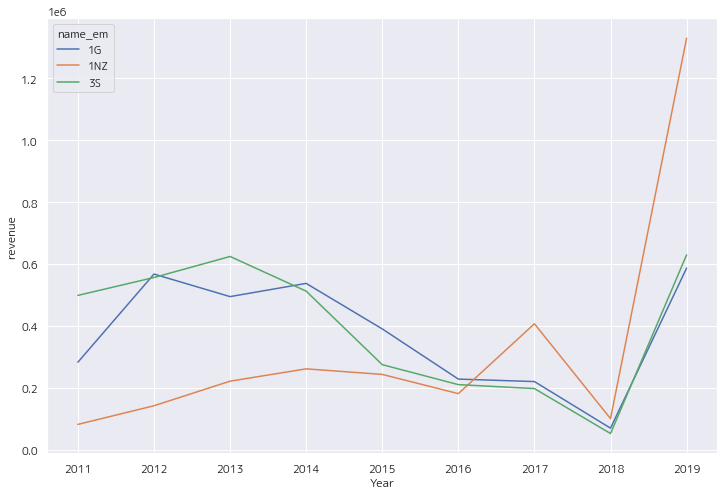

In [64]:
plt.figure(figsize=(12,8))
sns.lineplot(x='year',y='total_price',hue='name_em',data=df_group_year)
plt.ylabel('revenue')
plt.xlabel('Year')

In [157]:
df_group_month = df_best_engine.groupby(['month_year','name_em'])['total_price'].sum().reset_index()
df_group_month

,month_year,name_em,total_price
0,2011-01,1G,20116.273855
1,2011-01,1NZ,10564.127500
2,2011-01,3S,21307.790984
3,2011-02,1G,36304.160602
4,2011-02,1NZ,5591.174464
...,...,...,...
259,2019-11,1NZ,106630.202679
260,2019-11,3S,60247.034344
261,2019-12,1G,34137.352289
262,2019-12,1NZ,127636.058036


Text(0.5, 0, 'Month')

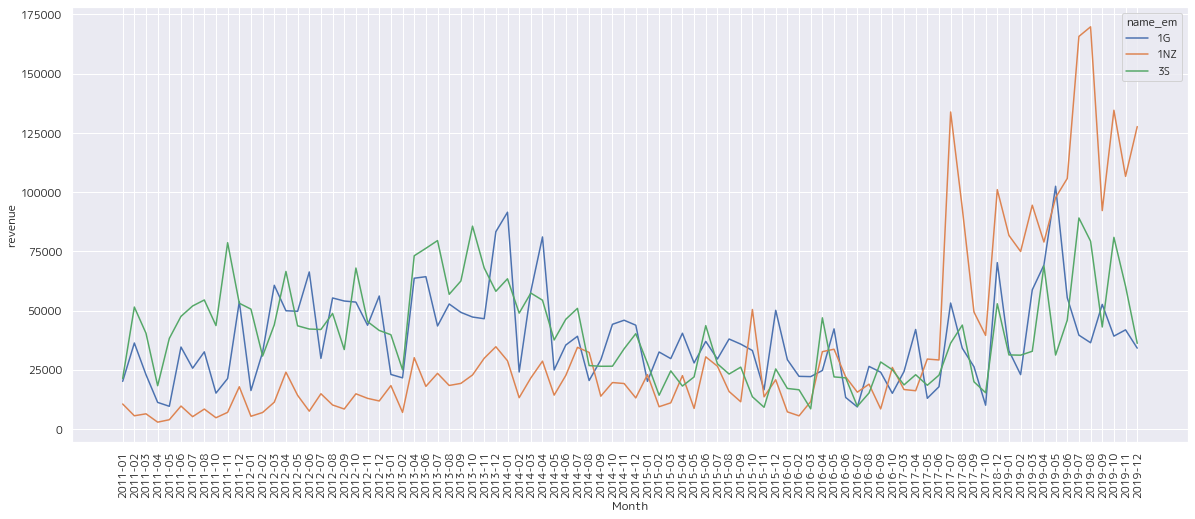

In [161]:
plt.figure(figsize=(20,8))
sns.lineplot(x='month_year',y='total_price',hue='name_em',data=df_group_month)
plt.xticks(rotation = 90)
plt.ylabel('revenue')
plt.xlabel('Month')

Text(0.5, 0, 'Month')

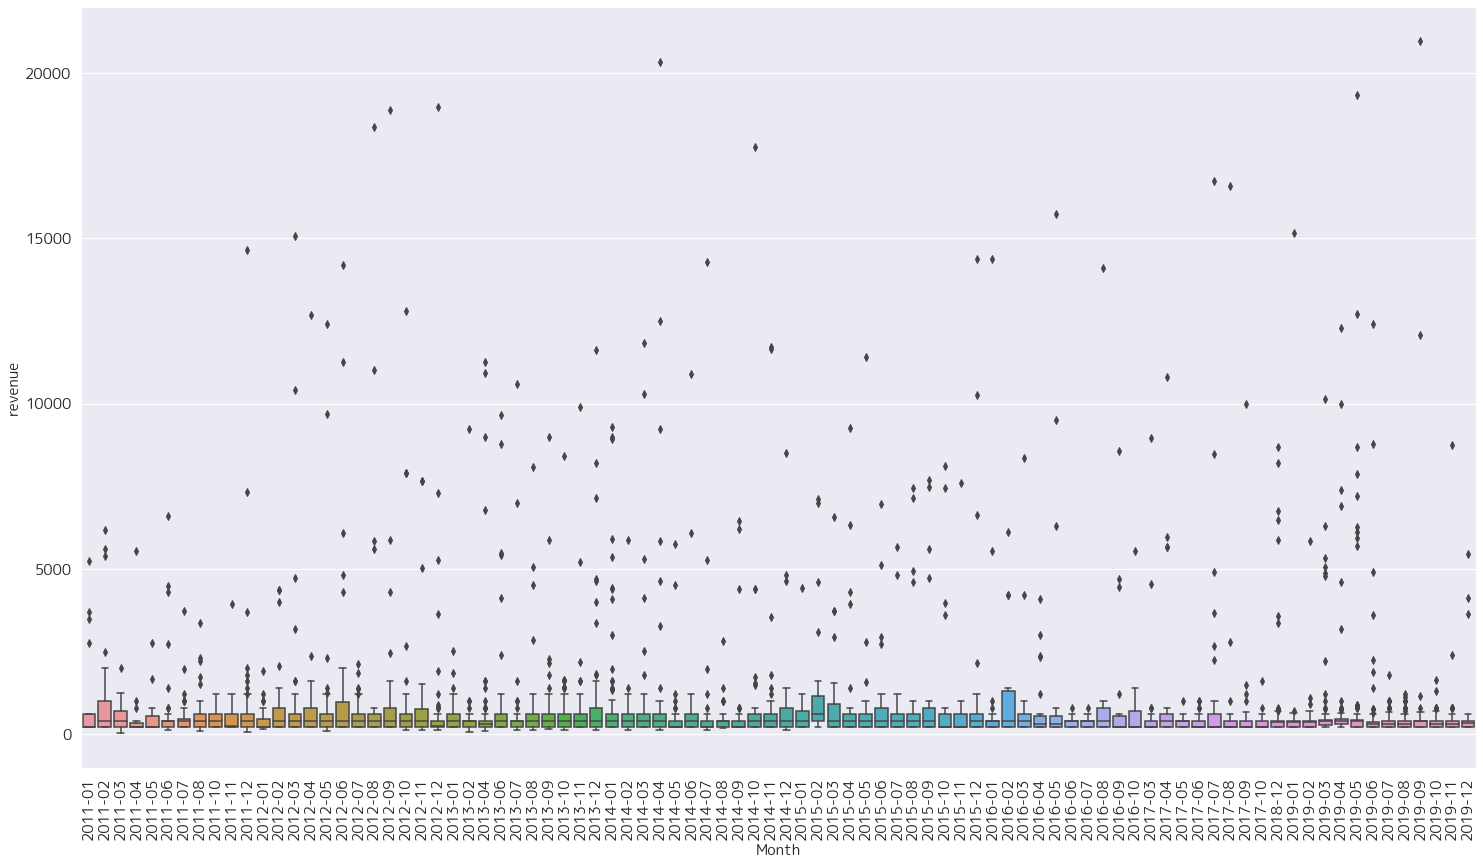

In [81]:
plt.figure(figsize=(25,14))
sns.boxplot(x='month_year',y='total_price',data=df_1g)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 15,rotation = 90, weight='bold')
plt.yticks(fontsize = 15)
plt.ylabel('revenue',fontsize = 15)
plt.xlabel('Month',fontsize = 15)

Text(0.5, 0, 'Year')

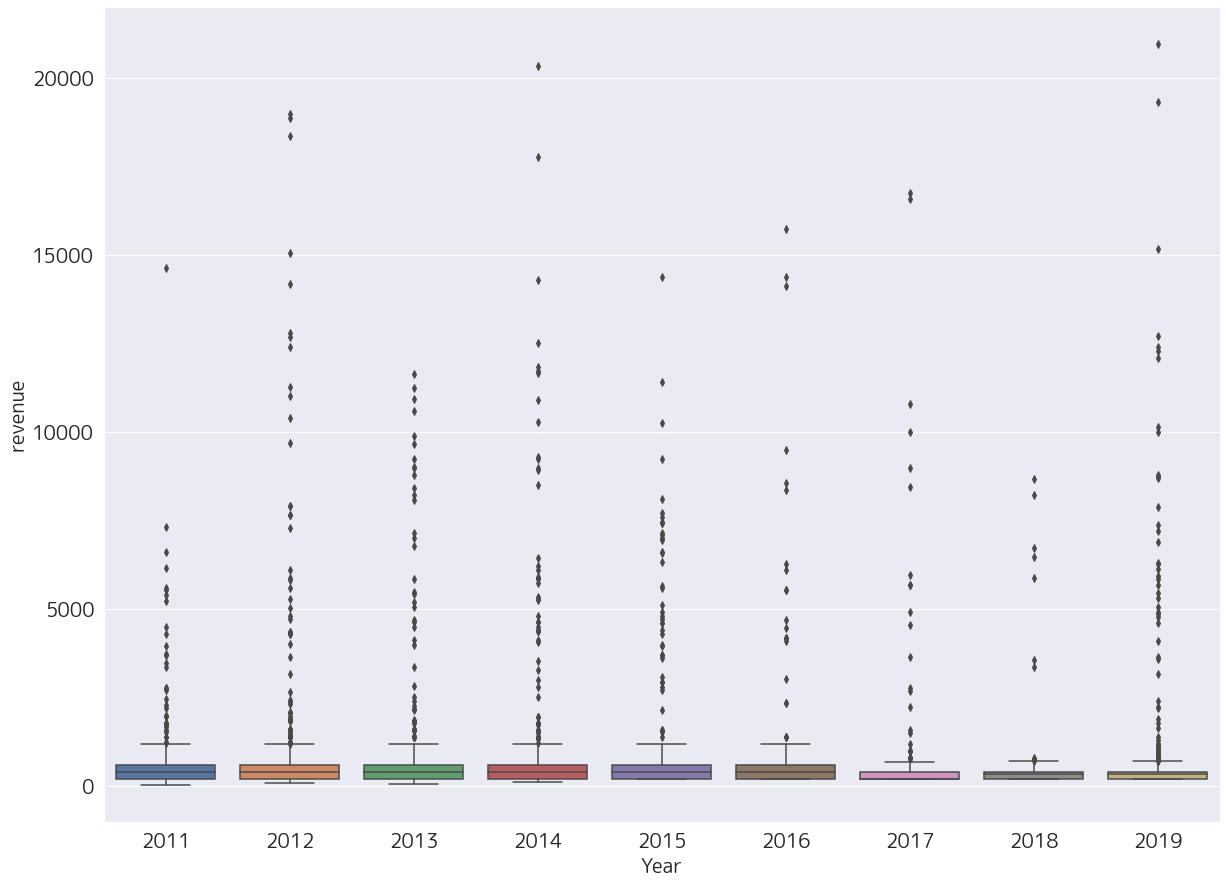

In [82]:
plt.figure(figsize=(20,15))
sns.boxplot(x='year',y='total_price',data=df_1g)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('revenue',fontsize = 20)
plt.xlabel('Year',fontsize = 20)